In [896]:
import numpy as np
import sympy as sp
from sympy import symbols, diff, solve, lambdify
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from numpy import sqrt
from matplotlib.pylab import sqrt
from sympy import lambdify
from tomlkit import ws



In [897]:
# Define Meterial properties and problem parameters
E = 28e9  # elastic modulus in PascalsN/m^2
L = 2 # length of the beam in meters
P = 5000 # applied load in Newtons at the end of the beam


In [898]:
#----------------------------Input----------------------------
NE = 2 # number of elements
ndof = NE + 1   # number of degrees of freedom
nldof = 2 # number of local degrees of freedom per element
print("Number of elements: ", NE)
print("Number of degrees of freedom: ", ndof)

Number of elements:  2
Number of degrees of freedom:  3


In [899]:
#---------------------------Generate Connectivity matrix for the mesh---------------------------
memID = np.zeros((NE, nldof), dtype=int)  # element ID
for i in range(NE):
    memID[i, :] = [i+1 , i + 2]  # node IDs for each element
print("Connectivity matrix (memID):\n", memID)

Connectivity matrix (memID):
 [[1 2]
 [2 3]]


In [900]:
h = L / NE  # length of each element
print("Element length (h): ", h)

Element length (h):  1.0


In [901]:
# create nodal coordinates from 0 to L in steps of element length h 
xnode2 = np.linspace(0, L, NE+1)  # or np.linspace(0, L, NE+1)
print("Nodal coordinates (xnode2):\n", xnode2)
area = lambda x: 0.25*(1 + x)
A = area(xnode2)  # cross-sectional area at each node
print("Cross-sectional area at nodes (A):\n", A)

Nodal coordinates (xnode2):
 [0. 1. 2.]
Cross-sectional area at nodes (A):
 [0.25 0.5  0.75]


In [902]:
bx= 25000 # Body force per unit volume (N/m^3)
print("Body force per unit volume (bx): ", bx, "N/m³")

Body force per unit volume (bx):  25000 N/m³


In [903]:
#---------------------------------------------Define Boundry Conditions---------------------------------------------
bdof = [3]  # Displacement boundary condition applied at node
bddisp = [0.0]  # Displacement value at the boundary condition node
txbdof = [1]  # Traction boundary condition applied at node
tx = [P]  # Traction value at the boundary condition node

In [904]:
#----------------------------------Processing----------------------------------#
Ae = np.zeros((2, NE))
aae = np.zeros(NE)

for i in range(NE):
    Ae[:, i] = [A[i], A[i+1]]
    aae[i] = np.mean(Ae[:, i])


In [905]:
#--------------------------------------------------define shape functions and their derivatives--------------------------------------------------


xi = sp.symbols('xi')
N1 = (1 - xi) / 2
N2 = (1 + xi) / 2

dN1_dxi = sp.diff(N1, xi)
dN2_dxi = sp.diff(N2, xi)

N_sym = sp.Matrix([N1, N2])                 # (2×1)
B_sym = sp.Matrix([dN1_dxi, dN2_dxi])       # (2×1) 

N_func = sp.lambdify(xi, N_sym, modules='numpy')
B_func = sp.lambdify(xi, B_sym, modules='numpy')
w1 = 1
w2 = 1

In [906]:
#------------------------------------Local stiffness matrix and force vector calculation------------------------------------
kstiff = np.zeros((nldof, nldof, NE))
gp = 1/np.sqrt(3)
gps = np.array([-gp, gp])  # Gauss points for 2-point quadrature
ws = np.array([w1, w2])  # Weights for 2-point quadrature
for i in range(NE):
    fx = lambda xi_val: (2*E/h) * ((N_func(xi_val).T  @ Ae[:, i:i+1]).item()) * (B_func(xi_val)  @ B_func(xi_val).T)
    kstiff[:, :, i] = fx(gp) + fx(-gp)

In [907]:
#----------------------------------Assemble global stiffness matrix and force vector----------------------------------
K_global = np.zeros((ndof, ndof))
F_global = np.zeros(ndof)

for i in range(NE):

    nodes = memID[i, :] - 1  # element nodes

    # Assemble stiffness
    K_global[np.ix_(nodes, nodes)] += kstiff[:, :, i]

    # Assemble force (consistent load)
    fe = np.zeros(nldof)

    for w, gp in zip(ws, gps):
        N = N_func(gp).astype(float).reshape(-1,1)
        Axi = float((N.T @ Ae[:, i:i+1]).item())
        fe += (w * (bx * Axi * (h/2)) * N.flatten())

    F_global[nodes] += fe

print("Global stiffness matrix:\n", K_global)


Global stiffness matrix:
 [[ 1.05e+10 -1.05e+10  0.00e+00]
 [-1.05e+10  2.80e+10 -1.75e+10]
 [ 0.00e+00 -1.75e+10  1.75e+10]]


In [908]:
#-----------------------Global force vector after assembly-----------------------
print("Global force vector:\n", F_global)

Global force vector:
 [ 4166.66666667 12500.          8333.33333333]


In [909]:
#----------------------------Apply displacement and traction boundary conditions----------------------------
# Apply displacement boundary conditions (Dirichlet BC)

for i in range(len(bdof)):
    dof = bdof[i] - 1          # convert to 0-based index
    disp = bddisp[i]

    F_global = F_global - K_global[:, dof] * disp

    K_global[:, dof] = 0
    K_global[dof, :] = 0
    K_global[dof, dof] = 1

    F_global[dof] = disp


# Apply traction boundary conditions (Neumann BC)

for i in range(len(txbdof)):
    dof = txbdof[i] - 1        # convert to 0-based index
    F_global[dof] += tx[i]

In [910]:
ufem2 = np.linalg.solve(K_global, F_global)
print("Displacements:\n", u)

Displacements:
 [2.11111111e-06 1.23809524e-06 0.00000000e+00]


In [911]:
# -------------------------------------------------------------Post Processing --------------------------------------------------------------

ue = np.zeros((nldof, NE))
for i in range(NE):
    for j in range(nldof):
        Grow = memID[i, j] - 1          # MATLAB->Python index
        ue[j, i] = ufem2[Grow]

# Calculate strains/stresses
xvec2 = []
Sigfem2 = []

for i in range(NE):
    ulocal = ue[:, i].reshape(-1, 1)    # (nldof×1)

    sige = lambda xi_val: (E * 2 / h) * (B_func(xi_val).T @ ulocal)  # (1×1)

    xvec2 += [xnode2[i], xnode2[i+1]]
    Sigfem2 += [sige(-1.0).item(), sige(1.0).item()]

xvec2 = np.array(xvec2, dtype=float)
Sigfem2 = np.array(Sigfem2, dtype=float)

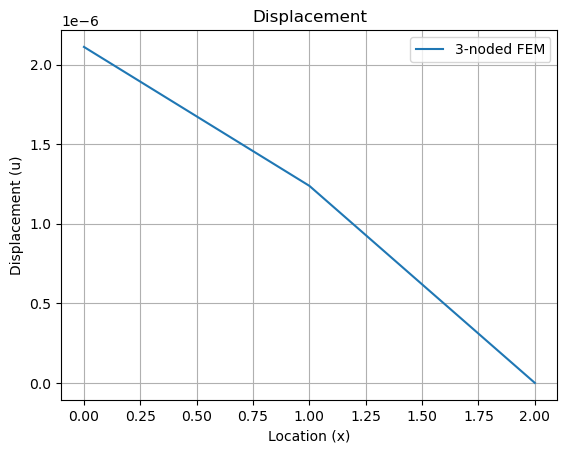

In [912]:

ufem2 = np.array(ufem2).flatten()
plt.figure(1)
plt.plot(xnode2, ufem2, '-', linewidth=1.5)
plt.xlabel('Location (x)')
plt.ylabel('Displacement (u)')
plt.title('Displacement')
plt.legend(['3-noded FEM'], loc='best')
plt.grid(True)

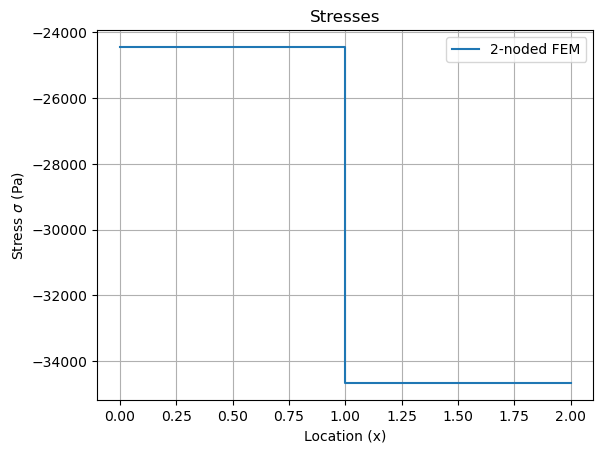

In [913]:
# ----------------- Figure 2 : Stress -----------------
plt.figure(2)
plt.plot(xvec2, Sigfem2, '-', linewidth=1.5)
plt.xlabel('Location (x)')
plt.ylabel(r'Stress $\sigma$ (Pa)')   # LaTeX formatting
plt.title('Stresses')
plt.legend(['2-noded FEM'], loc='best')
plt.grid(True)
plt.show()